Analyses properties of decorrelation and whitening methods for decorrelated networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
from decorrelation.decorrelation import Decorrelation, DecorLinear, DecorConv2d
import matplotlib.pyplot as plt
import matplotlib
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from decorrelation.utils import decor_train
import argparse
from decorrelation.plotting import *

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5), (0.5)),
        # torch.flatten # not necessary but useful for debugging
        ])

train_data = MNIST(root='~/Data', train=True, download=True, transform=transform)
train_data = Subset(train_data, np.random.permutation(len(train_data.data))[:1000])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [3]:
args = argparse.Namespace(lr=0.0, kappa=1e-2, decor_lr=1e-1, epochs=20)

model = Decorrelation(784, decor_lr=args.decor_lr, kappa=args.kappa).to(device)

lossfun = lambda x, y: nn.Parameter(torch.zeros(1, device=device, dtype=float), requires_grad=True)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 0.000000	decorrelation loss: 6.593070	test loss: 0.000000
epoch 1  	time:0.529 s	bp loss: 0.000000	decorrelation loss: 2.392300	test loss: 0.000000
epoch 2  	time:0.521 s	bp loss: 0.000000	decorrelation loss: 0.515656	test loss: 0.000000
epoch 3  	time:0.531 s	bp loss: 0.000000	decorrelation loss: 0.260103	test loss: 0.000000
epoch 4  	time:0.534 s	bp loss: 0.000000	decorrelation loss: 0.174338	test loss: 0.000000
epoch 5  	time:0.528 s	bp loss: 0.000000	decorrelation loss: 0.134951	test loss: 0.000000
epoch 6  	time:0.527 s	bp loss: 0.000000	decorrelation loss: 0.111709	test loss: 0.000000
epoch 7  	time:0.525 s	bp loss: 0.000000	decorrelation loss: 0.096316	test loss: 0.000000
epoch 8  	time:0.523 s	bp loss: 0.000000	decorrelation loss: 0.088545	test loss: 0.000000
epoch 9  	time:0.525 s	bp loss: 0.000000	decorrelation loss: 0.083344	test loss: 0.000000
epoch 10 	time:0.528 s	bp loss: 0.000000	decorrelation loss: 0.079147	test loss: 0.000000
epoch 11 	

layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.02
mean variance after decorrelation: 0.39



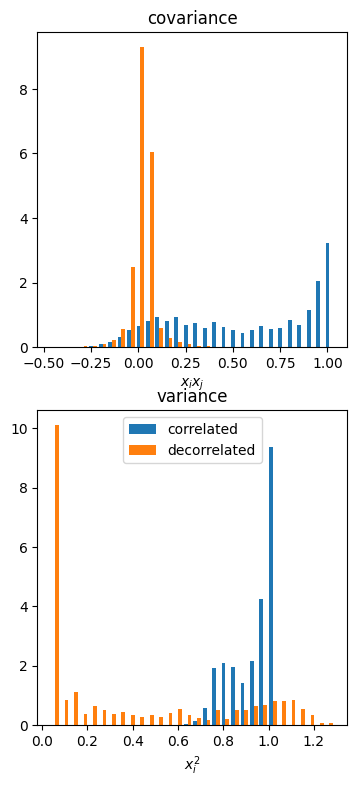

In [4]:
init_model = Decorrelation(784, decor_lr=args.decor_lr, kappa=args.kappa).to(device)
plot_correlations(init_model, model, train_loader, device=device)

In [7]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, kappa=args.kappa))

    def forward(self, x):
        return super().forward(x.view(len(x), -1))
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 5.035145	decorrelation loss: 6.610292	test loss: 0.000000
epoch 1  	time:0.693 s	bp loss: 4.524011	decorrelation loss: 2.386983	test loss: 0.000000
epoch 2  	time:0.584 s	bp loss: 3.910068	decorrelation loss: 0.514903	test loss: 0.000000
epoch 3  	time:0.551 s	bp loss: 3.565938	decorrelation loss: 0.258899	test loss: 0.000000
epoch 4  	time:0.544 s	bp loss: 3.317747	decorrelation loss: 0.174053	test loss: 0.000000
epoch 5  	time:0.547 s	bp loss: 3.112917	decorrelation loss: 0.133697	test loss: 0.000000
epoch 6  	time:0.550 s	bp loss: 2.936212	decorrelation loss: 0.111163	test loss: 0.000000
epoch 7  	time:0.545 s	bp loss: 2.778154	decorrelation loss: 0.097031	test loss: 0.000000
epoch 8  	time:0.549 s	bp loss: 2.628707	decorrelation loss: 0.088943	test loss: 0.000000
epoch 9  	time:0.544 s	bp loss: 2.488548	decorrelation loss: 0.084621	test loss: 0.000000
epoch 10 	time:0.546 s	bp loss: 2.359144	decorrelation loss: 0.080439	test loss: 0.000000


layer 1:

mean covariance before decorrelation: 0.56
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.22
mean variance after decorrelation: 0.55



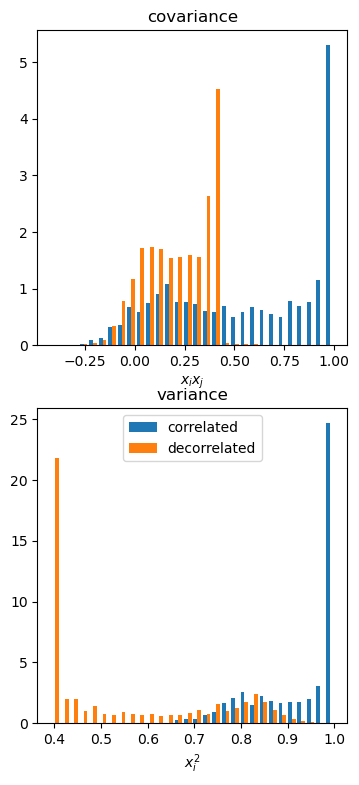

In [ ]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device=device)

In [ ]:
args = argparse.Namespace(lr=1e-4, decor_lr=1e-1, kappa=1e-2, epochs=10)

class Model(nn.Sequential):
    def __init__(self, in_features, args):
        super().__init__(DecorLinear(in_features, 100, decor_lr=args.decor_lr, kappa=args.kappa),
                        nn.LeakyReLU(),
                        DecorLinear(100, 10, decor_lr=args.decor_lr, kappa=args.kappa)
                        )

    def forward(self, x):
        return super().forward(x.view(len(x), -1))

# class Model(nn.Sequential):
#     def __init__(self, in_features, eta, whiten):
#         super().__init__(Decorrelation(in_features, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(in_features),
#                         nn.Linear(in_features, 100),
#                         nn.LeakyReLU(),
#                         Decorrelation(100, bias=False, eta=eta, whiten=whiten),
#                         nn.BatchNorm1d(100),
#                         nn.Linear(100, 10)
#                         )
    
model = Model(784, args).to(device)

lossfun = torch.nn.CrossEntropyLoss().to(device)

res = decor_train(args, model, lossfun, train_loader, device=device)

epoch 0  	time:0.000 s	bp loss: 2.466652	decorrelation loss: 6.813346
epoch 1  	time:0.460 s	bp loss: 2.374684	decorrelation loss: 2.747993
epoch 2  	time:0.507 s	bp loss: 2.126681	decorrelation loss: 1.128617
epoch 3  	time:0.479 s	bp loss: 1.818317	decorrelation loss: 1.188578
epoch 4  	time:0.457 s	bp loss: 1.498712	decorrelation loss: 1.335160
epoch 5  	time:0.511 s	bp loss: 1.218091	decorrelation loss: 1.453138
epoch 6  	time:0.469 s	bp loss: 1.036211	decorrelation loss: 1.469717
epoch 7  	time:0.454 s	bp loss: 0.896981	decorrelation loss: 1.456682
epoch 8  	time:0.461 s	bp loss: 0.826158	decorrelation loss: 1.490682
epoch 9  	time:0.481 s	bp loss: 0.771891	decorrelation loss: 1.481043
epoch 10 	time:0.635 s	bp loss: 0.763322	decorrelation loss: 1.606067


layer 1:

mean covariance before decorrelation: 0.58
mean variance before decorrelation: 0.93

mean covariance after decorrelation: 0.00
mean variance after decorrelation: 0.75

layer 2:

mean covariance before decorrelation: 0.07
mean variance before decorrelation: 0.20

mean covariance after decorrelation: 0.05
mean variance after decorrelation: 1.00



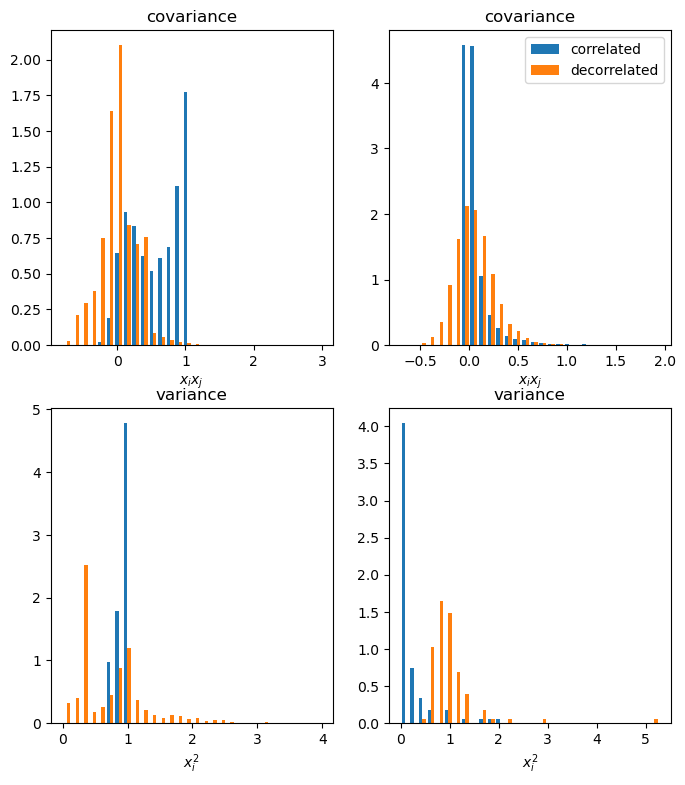

In [ ]:
init_model = Model(784, args).to(device)
plot_correlations(init_model, model, train_loader, device=device)